In [1]:
import torch

torch.manual_seed(0)

import gpytorch
import botorch

from botorch.exceptions.warnings import BotorchTensorDimensionWarning

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["image.cmap"] = "magma"

from tqdm.notebook import tqdm

import warnings

import os
import numpy as np

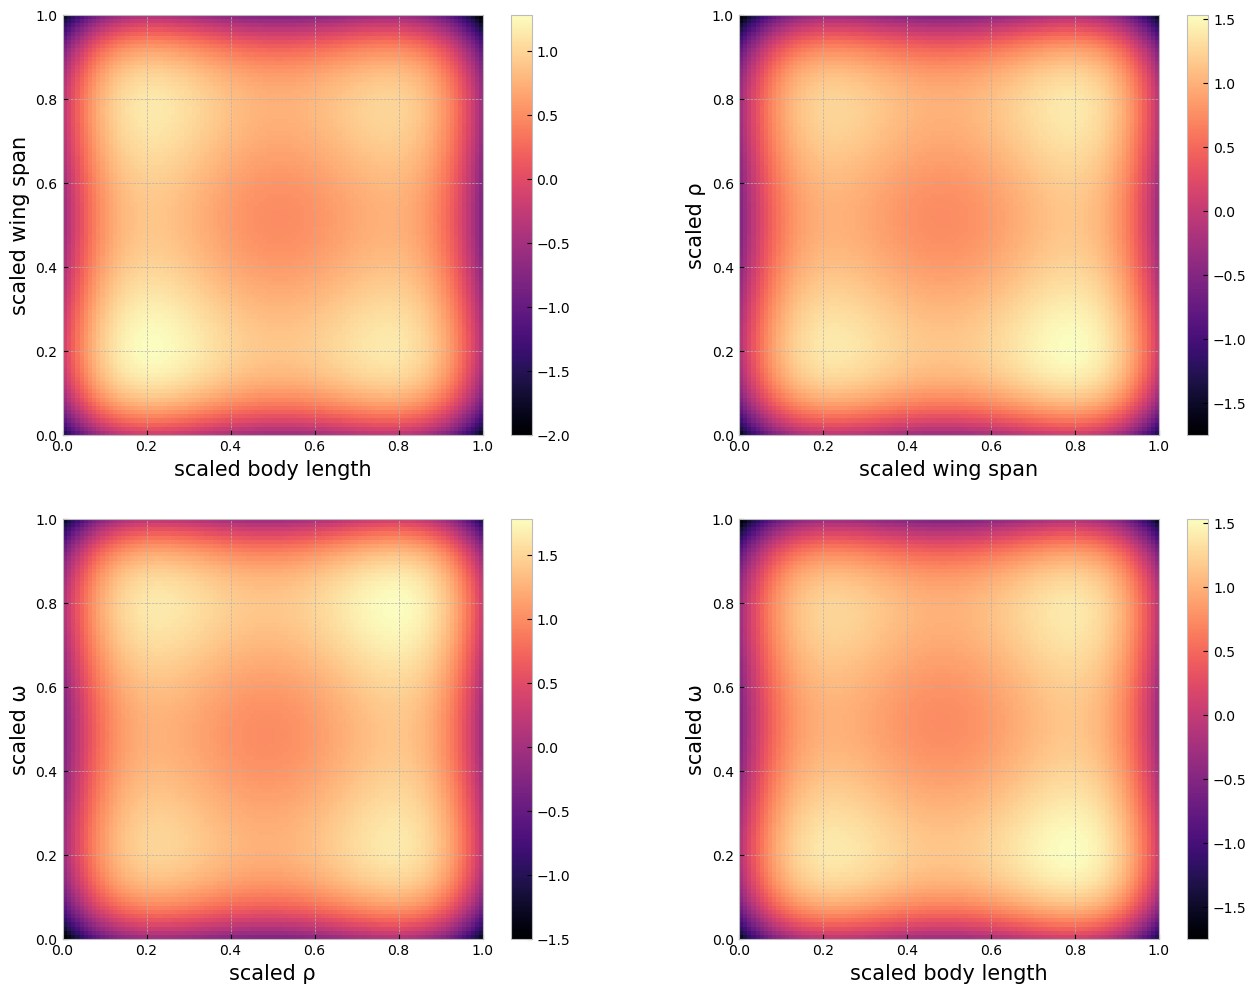

In [2]:
labels = ["scaled body length", "scaled wing span", "scaled ρ", "scaled ω"]


def visualize_objective(f):
    dimensions_to_plot = [(0, 1), (1, 2), (2, 3), (0, 3)]

    grid_x = torch.linspace(0, 1, 101)
    grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
    grid_x1 = grid_x1.flatten()
    grid_x2 = grid_x2.flatten()

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    for ax_ind, (i, j) in enumerate(dimensions_to_plot):
        tmp_ax = ax[ax_ind // 2][ax_ind % 2]

        xs = torch.zeros(101 ** 2, 4)
        xs[:, i] = grid_x1
        xs[:, j] = grid_x2

        c = tmp_ax.imshow(
            f(xs).reshape(101, 101),
            origin="lower",
            extent=[0, 1, 0, 1],
        )
        plt.colorbar(c, ax=tmp_ax)

        tmp_ax.set_xlabel(labels[i], fontsize=15)
        tmp_ax.set_ylabel(labels[j], fontsize=15)

    plt.show()


def flight_utility(X):
    X_copy = X.detach().clone()
    X_copy[:, [2, 3]] = 1 - X_copy[:, [2, 3]]
    X_copy = X_copy * 10 - 5

    return -0.005 * (X_copy ** 4 - 16 * X_copy ** 2 + 5 * X_copy).sum(dim=-1) + 3


visualize_objective(flight_utility)

In [3]:
first_target = 0.2096466
second_target = 0.7903534

flight_utility(
    torch.tensor([[first_target, first_target, second_target, second_target]])
)

tensor([4.5666])

In [4]:
class GPModel(
    gpytorch.models.ExactGP,
    botorch.models.gpytorch.GPyTorchModel,
    botorch.models.model.FantasizeMixin
):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=4)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [5]:
lb = 0
ub = 1

bounds = torch.tensor([[lb] * 4, [ub] * 4], dtype=torch.float)

num_experiments = 5

num_queries = 100
batch_size = 5
num_iters = num_queries // batch_size

In [6]:
class ignore_warnings:
    def __enter__(self):
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=BotorchTensorDimensionWarning)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.resetwarnings()

In [7]:
strategy = "mes"  # "poi", "ei", "ucb", "ts", or "mes"
strategy = strategy.upper()

num_candidates = 5000

incumbents = torch.zeros((num_experiments, num_iters))

pbar = tqdm(total=num_experiments * num_iters)

for exp in range(num_experiments):
    torch.manual_seed(exp)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 4)
    train_y = flight_utility(train_x)

    for i in range(num_iters):
        incumbents[exp, i] = train_y.max()

        model, likelihood = fit_gp_model(train_x, train_y)

        if strategy == "POI":
            policy = botorch.acquisition.monte_carlo.qProbabilityOfImprovement(
                model, best_f=train_y.max()
            )

        if strategy == "EI":
            policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
                model, best_f=train_y.max()
            )

        if strategy == "UCB":
            policy = botorch.acquisition.monte_carlo.qUpperConfidenceBound(
                model, beta=2
            )

        if strategy in ["POI", "EI", "UCB"]:
            with ignore_warnings():
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    q=batch_size,
                    num_restarts=100,
                    raw_samples=200,
                )
        else:
            sobol = torch.quasirandom.SobolEngine(4, scramble=True)
            candidate_x = sobol.draw(num_candidates)
            candidate_x = (bounds[1] - bounds[0]) * candidate_x + bounds[0]

            if strategy == "TS":
                with ignore_warnings():
                    ts = botorch.generation.MaxPosteriorSampling(model, replacement=False)
                    next_x = ts(candidate_x, num_samples=batch_size)

            if strategy == "MES":
                policy = botorch.acquisition.max_value_entropy_search.qMaxValueEntropy(
                    model, candidate_x
                )
                
                with ignore_warnings():
                    next_x, acq_val = botorch.optim.optimize_acqf_cyclic(
                        policy,
                        bounds=bounds,
                        q=batch_size,
                        num_restarts=40,
                        raw_samples=100,
                        cyclic_options={"maxiter": 5},
                    )

        next_y = flight_utility(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

        pbar.update()

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
torch.save(
    incumbents,
    f"./airplane_design/{strategy}.pth"
)

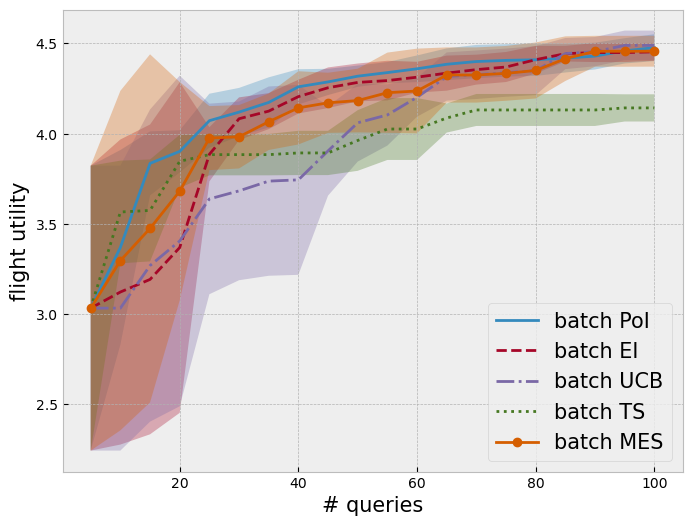

In [9]:
xs = (torch.arange(num_iters) + 1) * batch_size


def show_agg_progress(path, name, linestyle="solid"):
    def ci(y):
        return 2 * y.std(axis=0) / np.sqrt(num_experiments)

    incumbents = torch.load(path)
    avg_incumbent = incumbents.mean(axis=0)
    ci_incumbent = ci(incumbents)

    plt.plot(xs, avg_incumbent, linestyle, label=name)
    plt.fill_between(
        xs,
        avg_incumbent + ci_incumbent,
        avg_incumbent - ci_incumbent,
        alpha=0.3,
    )


show_agg_progress("./airplane_design/POI.pth", "batch PoI", "-")

show_agg_progress("./airplane_design/EI.pth", "batch EI", "--")

show_agg_progress("./airplane_design/UCB.pth", "batch UCB", "-.")

show_agg_progress("./airplane_design/TS.pth", "batch TS", ":")

show_agg_progress("./airplane_design/MES.pth", "batch MES", "o-")

plt.xlabel("# queries", fontsize=15)
plt.ylabel("flight utility", fontsize=15)
plt.legend(fontsize=15)

plt.show()